In [65]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [66]:
'''1. Initialize the relevant Parameters'''

# Share specific information;Risk free rate, Initial Stock price and Volatility
r = 0.1
S0 = 120
sigma = 0.25
# Put Option specific Information; Strike Price and Time Period (Years)
K = 100
T = 2
t = 0 # Time when option is being priced
phi = norm.cdf
kLog = np.log(K)

In [67]:
'''2.Calculate the analytical price for the put option using the closed-form solution. '''

def find_analytical_price(r,S0,K,sigma,T):
    d1 = (np.log(S0/K) + (r + sigma**2/2) * (T-t)) / (sigma * np.sqrt(T-t))
    d2 = d1 - sigma * np.sqrt(T)
    return - S0 * phi(-d1) + K * np.exp(-r * (T-t)) * phi(-d2)

In [68]:
analytical_put_price = find_analytical_price(r,S0,K,sigma,T)

In [69]:
'''3. Calculate the estimate for the put price using the characteristic function and technique described in note set 1. 
Use a maximum integral bound of 40 and N=200 rectangles to approximate your integral.'''

# Characteristic functions
def c_M1(t):
    return np.exp(1j * t * (np.log(S0) + (r - sigma**2/2) * T) - (sigma ** 2 * T * t**2/2))

def c_M2(t):
    return np.exp(1j * t * sigma**2 * T) * c_M1(t)

In [70]:
# Choosing integral upper bound and N, the number of partitions to sum over
t_max = 40
N = 200
delta = t_max / N
from_1_to_N = np.linspace(1,N,N)
t_n = (from_1_to_N - 1/2) * delta

Integral_1 = sum((((np.exp(-1j * t_n * kLog) * c_M2(t_n)).imag)/t_n) * delta)
Integral_2 = sum((((np.exp(-1j * t_n * kLog) * c_M1(t_n)).imag)/t_n) * delta)

fourier_put_val =  -S0 * (1/2 - Integral_1/np.pi) + np.exp(-r * T) * K * (1/2 - Integral_2/np.pi)

In [71]:
print("Analytical Put Price : {}".format(analytical_put_price))
print("Fourier Transform Put Price : {}".format(fourier_put_val))

Analytical Put Price : 2.4693867508857075
Fourier Transform Put Price : 2.46938675088572


In [80]:
'''4. Using this information, use the COS method to price a European put option using the given parameters. 
Calculate put prices for increasing upper limits on the COS method sum. Plot your results against the analytical put price.'''

# V_n = 2 * K * (upsilion_n(0,b2) - psi_n(0,b2)) / (b2-b1)

# Defining intermediate functions upsilon and psi

def upsilon_n(b2,b1,d,c,n):
    npi_d = np.pi * n * (d-b1)/(b2-b1)
    npi_c = np.pi * n * (c-b1)/(b2-b1)
    val_one = (np.cos(npi_d) * np.exp(d) - np.cos(npi_c) * np.exp(c))
    val_two = (n * np.pi * (np.sin(npi_d) * np.exp(d) - np.sin(npi_c) * np.exp(c)) / (b2-b1))
    return (val_one + val_two)/(1 + (n * np.pi / (b2-b1)) ** 2)

def psi_n(b2,b1,d,c,n):
    if n == 0:
        return d - c
    else:
        return (b2-b1) * (np.sin(n * np.pi * (d-b1)/(b2-b1)) - np.sin(n * np.pi * (c - b1) / (b2 - b1))) / (n * np.pi)

In [81]:
def v_n(K,b2,b1,n):
    return 2 * K * (psi_n(b2,b1,0,b1,n) - upsilon_n(b2,b1,0,b1,n)) / (b2 - b1)

def logchar_func(u,S0,r,sigma,K,T):
    return np.exp(1j * u * (np.log(S0/K) + (r - sigma**2 / 2) * T) - (sigma ** 2) * T * (u ** 2) / 2)

def put_price(N,S0,sigma,r,K,T,b2,b1):
    price = v_n(K,b2,b1,0) * logchar_func(0,S0,r,sigma,K,T)/2
    for n in range(1,N):
        price = price + logchar_func(n * np.pi / (b2-b1),S0,r,sigma,K,T) * np.exp(-1j * n * np.pi * b1/(b2-b1)) * v_n(K,b2,b1,n)
    return price.real * np.exp(-r * T)

In [88]:
c1 = r
c2 = T * sigma ** 2
c4 = 0
L = 10

b1 = c1 - L * np.sqrt(c2 - np.sqrt(c4))
b2 = c1 + L * np.sqrt(c2 - np.sqrt(c4))

#Calculating COS for various N
COS_put_price = [None]*50
for i in range(1,51):
    COS_put_price[i-1] = put_price(i,S0,sigma,r,K,T,b2,b1)

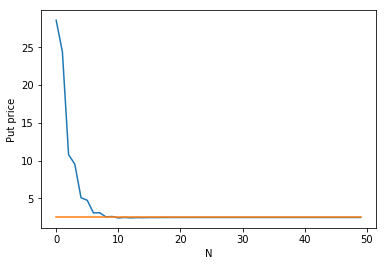

In [89]:
#Plotting the results
plt.plot(COS_put_price)
plt.plot([analytical_put_price]*50)
plt.xlabel("N")
plt.ylabel("Put price")
plt.show()

In [90]:
print("Fourier COS Put Price : {}".format(COS_put_price[-1]))

Fourier COS Put Price : 2.4693867508856937


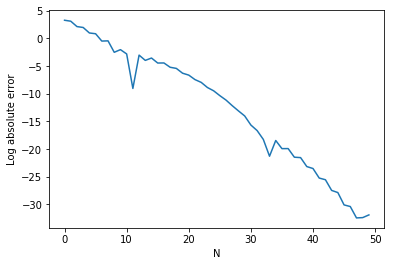

In [91]:
#plotting log of absolute error
plt.plot(np.log(np.absolute(COS_put_price - analytical_put_price)))
plt.xlabel("N")
plt.ylabel("Log absolute error")
plt.show()


In [ ]:
'''5. Use the fast Fourier transform (FFT) to price a European put option with the given parameters. 
You will have to price your put option for a range of strikes. Note that the only difference when applying the FFT to a put, 
when compared to a call, is that your value for α must be less than -1. Use a sequence length for your xn of N=210, and use 
δu=0.25. Plot the estimated put prices against the analytical put prices (across the range of strikes).
'''


In [231]:
# Fast Fourier Method information
alpha = -3
delta = 0.25
N = 2**10

In [232]:
# Characteristic functions
def log_char(u):
    return np.exp(1j * u * (np.log(S0) + (r - sigma**2/2) * T) - sigma**2 * T * u**2/2)

def c_func(v):
    val1 = np.exp(-r * T) * log_char(v - (alpha + 1) * 1j)
    val2 = alpha**2 + alpha - v**2 + 1j * (2 * alpha + 1) * v
    return val1/val2
    

In [233]:
n = np.array(range(N))
delta_k = 2 * np.pi / (N * delta)
b = delta_k * (N - 1) / 2
log_strike = np.linspace(-b,b,N)
x = np.exp(1j * b * n * delta) * c_func(n * delta) * delta
x[0] = x[0] * 0.5
x[-1] = x[-1] * 0.5
x_hat = np.fft.fft(x).real

In [234]:
# Find fft price and fft analytical price using e^K as strike 
fft_put_price = np.exp(-alpha * log_strike) * x_hat / np.pi
fft_analytical_price = find_analytical_price(r,S0,np.exp(log_strike),sigma,T)

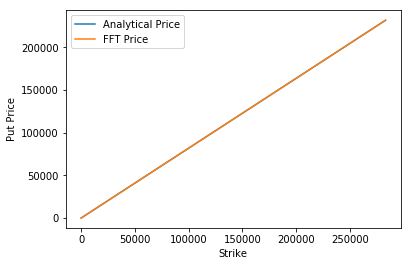

In [235]:
# Plot the graph
plt.plot(np.exp(log_strike),fft_analytical_price,label = "Analytical Price")
plt.plot(np.exp(log_strike),fft_put_price,label = "FFT Price")
plt.xlabel("Strike")
plt.ylabel("Put Price")
plt.legend(loc = "upper left")
plt.show()

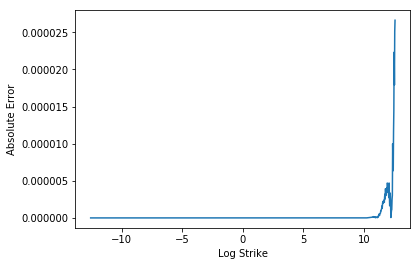

In [239]:
plt.plot((log_strike),(np.absolute(fft_put_price - fft_analytical_price)))
plt.xlabel("Log Strike")
plt.ylabel("Absolute Error")
plt.show()